# Quantum Galton Board (Binomial)

**Goal.** Build the paper’s Quantum Galton Board (QGB) and verify the unbiased board with $(N$) layers produces **Binomial$((N,\tfrac12)$)**, which approaches a **Gaussian**.

**Physical peg (module).** For neighbor bins $((b_j,b_{j+1})$) and a coin qubit:
1. Toss coin with $(R_X(\theta)$) (unbiased if \($theta=\pi/2$); bias by changing $(\theta$)).
2. `CSWAP(coin, b_j, b_{j+1})` moves the ball right **iff** coin is \(|1\rangle\).
3. `CNOT(b_{j+1} → coin)` **uncomputes** the coin: if a move happened, the coin is driven back to \(|0\rangle\).

**Layer composition (reset-free).**
- Wires: coins `c0..c{N-1}` (one fresh coin per layer) and bins `b0..bN`.
- Init: set `b0 = 1` (ball starts at leftmost bin).
- For layer \(\ell = 0..N-1\):
  - Apply \(R_X(\theta_\ell)\) on `cℓ`.
  - Sweep the **active triangle** **RIGHT→LEFT**: \((b_\ell,b_{\ell+1}), (b_{\ell-1},b_\ell), \dots, (b_0,b_1)\).
  - At the first pair that contains the ball, the peg acts once; `CNOT` clears the coin; remaining pairs are inert.

**Why RIGHT→LEFT?** Pairs to the right of the ball are \((0,0)\) and do nothing. The first active pair encountered contains the ball; after it acts, the coin is \(|0\rangle\) so the rest of the sweep cannot cause extra moves. Each row causes **at most one right step**, reproducing a classical Galton board.

**Verification.**
- Measure **only bins**; each shot returns a one-hot vector. The index \(k\in\{0..N\}\) is the number of right moves.
- For the unbiased case, expect \(\mathbb{E}[k]=N/2\), \(\mathrm{Var}[k]=N/4\); the histogram overlays the Binomial bars and looks Gaussian for large \(N\).


In [54]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from math import comb, pi

np.random.seed(0)

def binomial_pmf(N, p=0.5):
    return np.array([comb(N, k)*p**k*(1-p)**(N-k) for k in range(N+1)])

def tv_distance(p, q):
    p, q = np.asarray(p), np.asarray(q)
    return 0.5*np.abs(p-q).sum()

def summarize_and_plot(k, N, title):
    shots = len(k)
    emp   = np.array([np.mean(k==i) for i in range(N+1)])
    ideal = binomial_pmf(N, 0.5)
    mu, var = k.mean(), k.var()
    tvd = tv_distance(emp, ideal)

    print(f"N={N}, shots={shots}")
    print(f"  mean: {mu:.4f}   (ideal {N/2:.4f})")
    print(f"  var:  {var:.4f}  (ideal {N/4:.4f})")
    print(f"  TVD:  {tvd:.4e}")

    xs = np.arange(N+1)
    plt.figure(figsize=(7.5,3.8))
    plt.bar(xs, ideal, alpha=0.35, label="Ideal Binomial")
    plt.bar(xs, emp,   alpha=0.65, label="Empirical")
    plt.xlabel("Final bin index k (# right moves)")
    plt.ylabel("Probability")
    plt.title(title)
    plt.legend(); plt.tight_layout(); plt.show()


In [55]:
def peg_once(bin_wires, coin, j):
    """One physical peg at (b_j, b_{j+1})."""
    qml.CSWAP(wires=[coin, bin_wires[j], bin_wires[j+1]])
    qml.CNOT(wires=[bin_wires[j+1], coin])  # write-back: if we moved right, coin -> 0

def qgb_multicoin(N, shots=20_000, thetas=None):
    """N-layer Galton board with a fresh coin per layer (no mid-circuit reset)."""
    if thetas is None:
        thetas = [pi/2]*N  # unbiased
    coin_wires = [f"c{i}" for i in range(N)]
    bin_wires  = [f"b{i}" for i in range(N+1)]
    dev = qml.device("default.qubit", wires=coin_wires+bin_wires, shots=shots)

    @qml.qnode(dev)
    def circuit():
        qml.PauliX(wires=bin_wires[0])  # ball at leftmost bin
        for ell in range(N):
            qml.RX(thetas[ell], wires=coin_wires[ell])           # toss coin for this layer
            for j in range(ell, -1, -1):                         # RIGHT → LEFT sweep
                peg_once(bin_wires, coin_wires[ell], j)
        return qml.sample(wires=bin_wires)                       # measure bins only

    return circuit


# 1-Layer and 2-Layer check

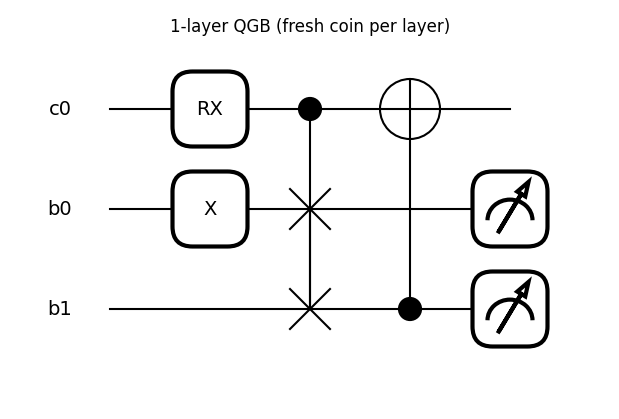

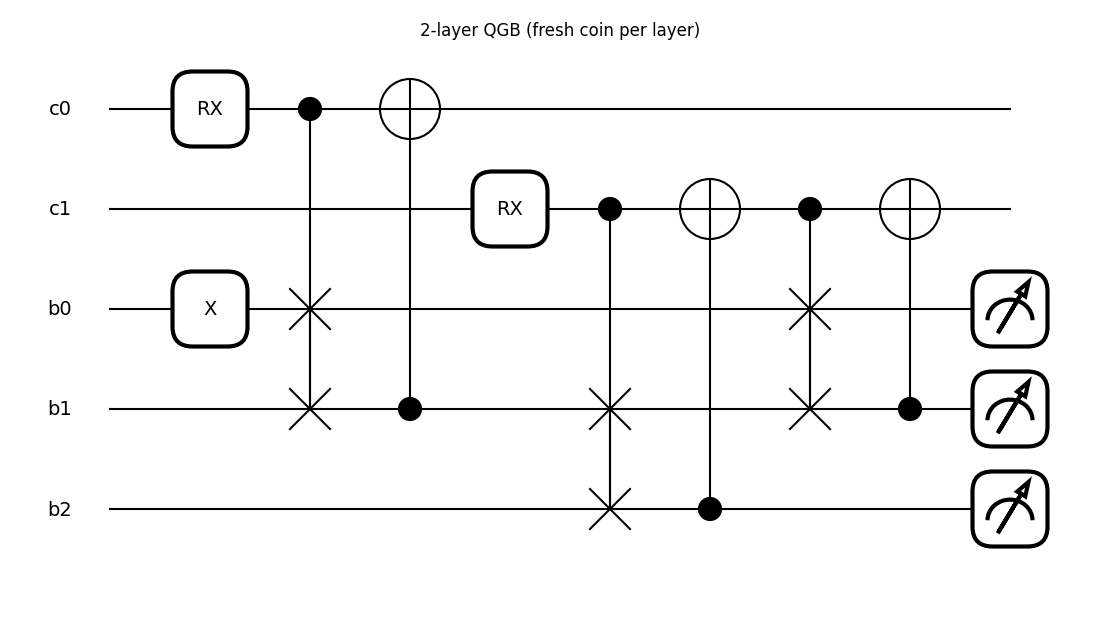

N=1, shots=20000
  mean: 0.5073   (ideal 0.5000)
  var:  0.2499  (ideal 0.2500)
  TVD:  7.3500e-03


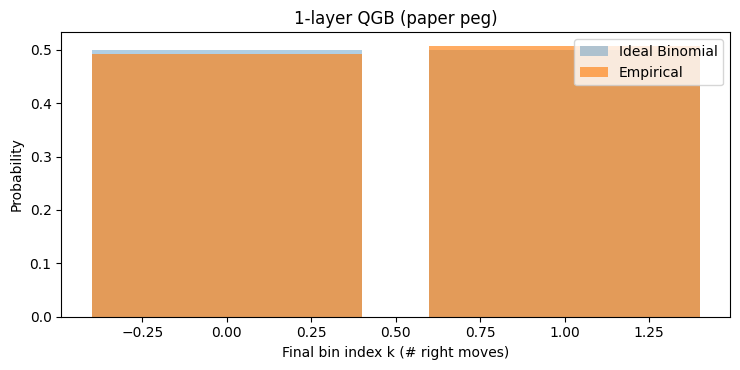

N=2, shots=40000
  mean: 1.0048   (ideal 1.0000)
  var:  0.4998  (ideal 0.5000)
  TVD:  2.5000e-03


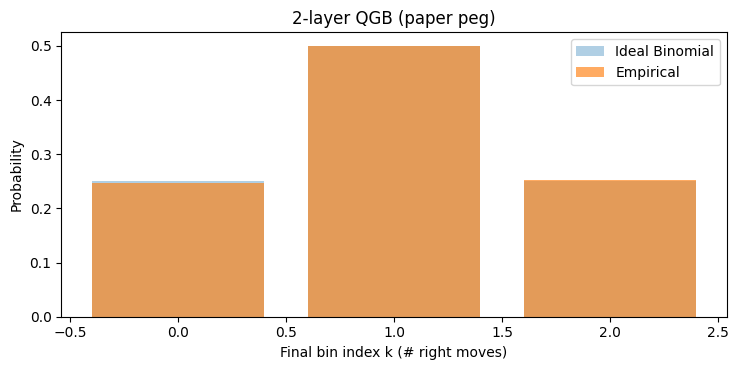

In [56]:
# 1-layer (N=1)
circ1 = qgb_multicoin(1, shots=1)
fig, ax = qml.draw_mpl(circ1)()
fig.suptitle("1-layer QGB (fresh coin per layer)"); plt.show()

# 2-layer (N=2)
circ2 = qgb_multicoin(2, shots=1)
fig, ax = qml.draw_mpl(circ2)()
fig.suptitle("2-layer QGB (fresh coin per layer)"); plt.show()

# Run and verify
circ1 = qgb_multicoin(1, shots=20_000)
k1 = np.argmax(circ1(), axis=1)
summarize_and_plot(k1, 1, "1-layer QGB (paper peg)")

circ2 = qgb_multicoin(2, shots=40_000)
k2 = np.argmax(circ2(), axis=1)
summarize_and_plot(k2, 2, "2-layer QGB (paper peg)")


# Gaussian Distribution 

N=12, shots=50000
  mean: 5.9995   (ideal 6.0000)
  var:  2.9884  (ideal 3.0000)
  TVD:  3.2087e-03


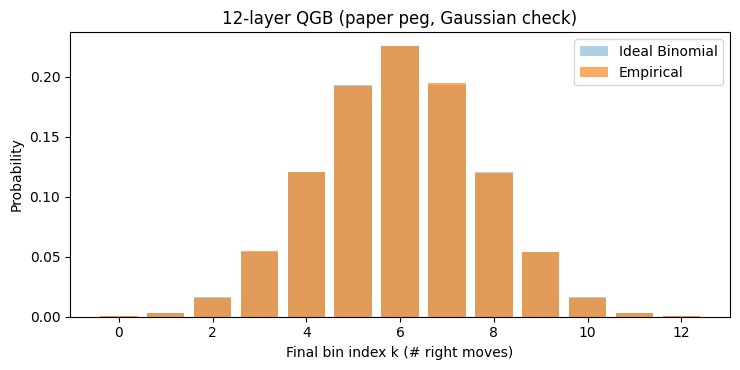

In [57]:
N, SHOTS = 12, 50_000
circN = qgb_multicoin(N, shots=SHOTS)
samples = circN()                          # shape: (shots, N+1), one-hot
k = np.argmax(samples, axis=1)             # final bin index = # of right moves
summarize_and_plot(k, N, f"{N}-layer QGB (paper peg, Gaussian check)")


# Exponential Distribution 

**Objective.** Sample from a *truncated discrete exponential* on integers \(k=0,\dots,N\):
\[
p_k = \frac{e^{-\lambda k}}{\sum_{j=0}^{N} e^{-\lambda j}}.
\]
Because we’re allowed an **all-to-all, noiseless** sampler, we directly prepare the quantum state whose **amplitude magnitudes** match \(\sqrt{p_k}\), then measure.

---

## Design in one page

### 1) Encoding
- Use a **number register** of \(m=\lceil \log_2(N+1)\rceil\) qubits to encode \(k\) in **binary**: \(|k\rangle\).
- Prepare
  \[
  |\psi\rangle=\sum_{k=0}^{N}\sqrt{p_k}\,|k\rangle,
  \]
  padding amplitudes for \(k>N\) with zeros so the vector has length \(2^m\).

### 2) State preparation (all-to-all)
- On a simulator we can load the full state in one shot:
  ```python
  qml.QubitStateVector(amp, wires=range(m))


In [63]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from math import ceil, log2

np.random.seed(0)

def exp_pmf(N, lam):
    """Truncated discrete exponential: p_k ∝ exp(-lam*k), k=0..N."""
    k = np.arange(N+1)
    w = np.exp(-lam * k)
    p = w / w.sum()
    return p

def bits_to_int(bits, endian="msb"):
    """Convert PennyLane sample bits to integers robustly."""
    if bits.ndim == 1:
        return bits.astype(int)
    m = bits.shape[1]
    if endian == "msb":       # wire 0 is MSB
        weights = 1 << np.arange(m-1, -1, -1)
    else:                     # wire 0 is LSB
        weights = 1 << np.arange(m)
    return (bits * weights).sum(axis=1).astype(int)

def summarize_vs_ideal(ints, N, ideal, title=""):
    shots = len(ints)
    counts = np.bincount(ints, minlength=N+1)[:N+1]
    emp = counts / shots

    xs = np.arange(N+1)
    mu_emp  = (xs * emp).sum()
    var_emp = (xs**2 * emp).sum() - mu_emp**2
    mu_id   = (xs * ideal).sum()
    var_id  = (xs**2 * ideal).sum() - mu_id**2
    tvd     = 0.5 * np.abs(emp - ideal).sum()

    print(f"N={N}, shots={shots}")
    print(f"  mean: {mu_emp:.4f}   (ideal {mu_id:.4f})")
    print(f"  var:  {var_emp:.4f}  (ideal {var_id:.4f})")
    print(f"  TVD:  {tvd:.4e}")

    plt.figure(figsize=(7.5,3.8))
    plt.bar(xs, ideal, alpha=0.35, label="Ideal Exponential")
    plt.bar(xs, emp,   alpha=0.65, label="Empirical (quantum)")
    plt.xlabel("k"); plt.ylabel("Probability")
    plt.title(title or "Exponential target (truncated)")
    plt.legend(); plt.tight_layout(); plt.show()


In [64]:
def exp_all_to_all_sampler(N, lam=0.35, shots=50_000):
    """
    Prepare |ψ> = sum_{k=0}^N sqrt(p_k) |k>,  p_k ∝ exp(-lam*k),
    on m = ceil(log2(N+1)) qubits (binary encoding).
    """
    m = max(1, ceil(log2(N+1)))
    D = 2**m
    p = exp_pmf(N, lam)
    amp = np.zeros(D, dtype=complex)
    amp[:N+1] = np.sqrt(p)  # exact amplitudes; rest zero

    dev = qml.device("default.qubit", wires=list(range(m)), shots=shots)

    @qml.qnode(dev)
    def circuit():
        # State preparation; use QubitStateVector; if unavailable, swap to StatePrep
        qml.QubitStateVector(amp, wires=range(m))
        return qml.sample(wires=range(m))

    return circuit, p


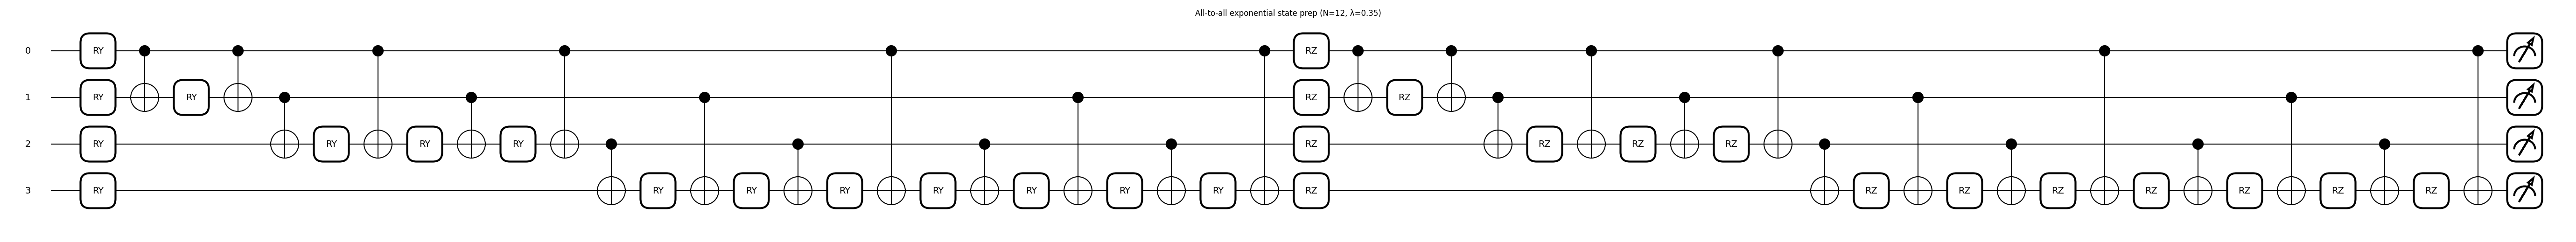

In [65]:
N, LAM = 12, 0.35
circ_draw, _ = exp_all_to_all_sampler(N, lam=LAM, shots=1)
fig, ax = qml.draw_mpl(circ_draw)()
fig.suptitle(f"All-to-all exponential state prep (N={N}, λ={LAM})")
plt.show()


N=12, shots=50000
  mean: 2.2440   (ideal 2.2474)
  var:  6.2462  (ideal 6.2562)
  TVD:  6.2017e-03


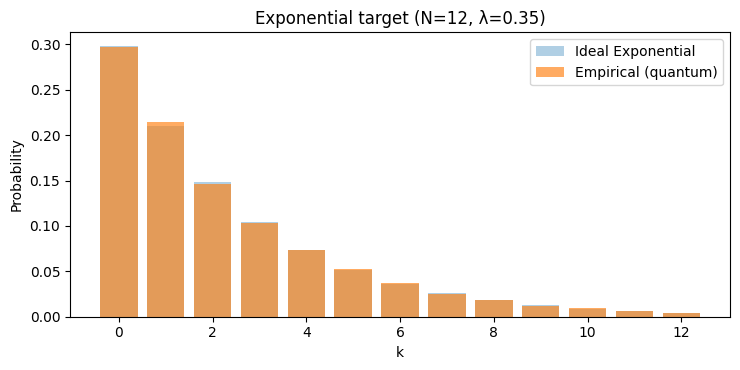

In [66]:
SHOTS = 50_000
circ, ideal = exp_all_to_all_sampler(N, lam=LAM, shots=SHOTS)
bits = circ()  # shape (shots, m) or (shots,) if m==1

# Try both endians; pick the one that yields ~zero mass beyond N (because amp[k>N]=0)
ints_msb = bits_to_int(bits, "msb")
ints_lsb = bits_to_int(bits, "lsb")
bad_msb  = np.count_nonzero(ints_msb > N)
bad_lsb  = np.count_nonzero(ints_lsb > N)
ints = ints_msb if bad_msb <= bad_lsb else ints_lsb

# Sanity check: there should be no counts for k>N (padding amplitudes are zero)
if np.count_nonzero(ints > N) > 0:
    raise RuntimeError("Mapping produced indices > N; check wire order or preparation.")

# Verify against ideal distribution
summarize_vs_ideal(ints, N, ideal, title=f"Exponential target (N={N}, λ={LAM})")


# Hadamard Quantum Walk — Noiseless all-to-all sampler

**Target.** The probability distribution of a **1D discrete-time Hadamard quantum walk** after \(T\) steps.  
Positions are \(x\in\{-T,\dots,+T\}\) (only sites with the same parity as \(T\) have nonzero probability).

**Plan.**
1. **Compute the ideal distribution** \(p_x\) classically: each step applies a Hadamard coin
   \(H=\frac{1}{\sqrt2}\begin{pmatrix}1&1\\1&-1\end{pmatrix}\) to the coin, then a **conditional shift**
   (coin=0 → move right, coin=1 → move left).  
   We pick the common **symmetric initial coin** \((|0\rangle+i|1\rangle)/\sqrt2\) so the walk is symmetric.
2. Build a **number register** of \(m=\lceil\log_2(2T+1)\rceil\) qubits that encodes the
   integer index \(k=x+T\in\{0,\dots,2T\}\).
3. **All-to-all state prep:** load \(|\psi\rangle=\sum_{k=0}^{2T}\sqrt{p_k}\,|k\rangle\) with
   `QubitStateVector`. (Remaining amplitudes are padded with zeros.)
4. **Sample** the register and convert bitstrings to integers with an **endian-safe** helper.
5. **Verify**: histogram vs. ideal \(p_k\), plus mean/variance and **TVD**.

**Why this is correct.**
- We prepare the **exact** amplitude square-roots of the target Hadamard-walk distribution, so on an ideal simulator the empirical histogram converges to the ideal within sampling error.
- Using a number register and all-to-all state prep satisfies the “noiseless all-to-all sampler” requirement.


In [67]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from math import ceil, log2

np.random.seed(0)

def bits_to_int(bits, endian="msb"):
    """Convert PennyLane sample bits to integers robustly."""
    if bits.ndim == 1:
        return bits.astype(int)
    m = bits.shape[1]
    if endian == "msb":       # wire 0 is MSB
        weights = 1 << np.arange(m-1, -1, -1)
    else:                     # wire 0 is LSB
        weights = 1 << np.arange(m)
    return (bits * weights).sum(axis=1).astype(int)

def summarize_vs_ideal(ints, ideal, title=""):
    N = len(ideal) - 1
    shots = len(ints)
    counts = np.bincount(ints, minlength=N+1)[:N+1]
    emp = counts / shots

    xs = np.arange(N+1)
    mu_emp  = (xs * emp).sum()
    var_emp = (xs**2 * emp).sum() - mu_emp**2
    mu_id   = (xs * ideal).sum()
    var_id  = (xs**2 * ideal).sum() - mu_id**2
    tvd     = 0.5 * np.abs(emp - ideal).sum()

    print(f"N={N}, shots={shots}")
    print(f"  mean: {mu_emp:.4f}   (ideal {mu_id:.4f})")
    print(f"  var:  {var_emp:.4f}  (ideal {var_id:.4f})")
    print(f"  TVD:  {tvd:.4e}")

    plt.figure(figsize=(7.5,3.8))
    plt.bar(xs, ideal, alpha=0.35, label="Ideal Hadamard QW")
    plt.bar(xs, emp,   alpha=0.65, label="Empirical (quantum)")
    plt.xlabel("k = x + T   (index, with x∈[-T..T])"); plt.ylabel("Probability")
    plt.title(title or "Hadamard quantum walk target (truncated)")
    plt.legend(); plt.tight_layout(); plt.show()


In [68]:
def hadamard_qw_distribution(T, init_coin=("sym",)):
    """
    Returns p (length 2T+1), where p[k] = Prob(x = k-T) after T steps.
    init_coin:
      ("sym",) uses (|0> + i|1>)/sqrt(2) for symmetry.
      or pass a tuple of complex amplitudes (alpha, beta) with |alpha|^2+|beta|^2=1.
    """
    L = 2*T + 1                 # positions x = -T..+T  → indices k = 0..2T
    off = T                     # index shift: k = x + T

    # Initial coin state
    if init_coin and init_coin[0] == "sym":
        alpha, beta = 1/np.sqrt(2), 1j/np.sqrt(2)
    else:
        alpha, beta = init_coin

    # amplitudes for coin=0 and coin=1 at each position index k
    psi0 = np.zeros(L, dtype=complex)
    psi1 = np.zeros(L, dtype=complex)
    psi0[off] = alpha
    psi1[off] = beta

    H = (1/np.sqrt(2)) * np.array([[1, 1],
                                   [1, -1]], dtype=complex)

    for _ in range(T):
        # Coin toss (Hadamard) at each site
        a = psi0.copy()
        b = psi1.copy()
        psi0 = H[0,0]*a + H[0,1]*b
        psi1 = H[1,0]*a + H[1,1]*b

        # Conditional shift: coin-0 moves right (k -> k+1), coin-1 moves left (k -> k-1)
        n0 = np.zeros_like(psi0)
        n1 = np.zeros_like(psi1)
        n0[1:] += psi0[:-1]     # right
        n1[:-1] += psi1[1:]     # left
        psi0, psi1 = n0, n1

    p = (np.abs(psi0)**2 + np.abs(psi1)**2)
    p = p / p.sum()             # normalize (guard against boundary loss)
    return p


In [69]:
def hadamard_qw_all_to_all_sampler(T, shots=50_000, init_coin=("sym",)):
    """
    Prepares |ψ> = sum_{k=0}^{2T} sqrt(p_k) |k>, where p_k is the Hadamard-QW distribution.
    Uses a number register with m = ceil(log2(2T+1)) qubits (binary encoding).
    """
    p = hadamard_qw_distribution(T, init_coin=init_coin)
    N = len(p) - 1                                  # N = 2T
    m = max(1, ceil(log2(N+1)))
    D = 2**m

    amp = np.zeros(D, dtype=complex)
    amp[:N+1] = np.sqrt(p)                          # exact amplitudes

    dev = qml.device("default.qubit", wires=list(range(m)), shots=shots)

    @qml.qnode(dev)
    def circuit():
        qml.QubitStateVector(amp, wires=range(m))
        return qml.sample(wires=range(m))

    return circuit, p


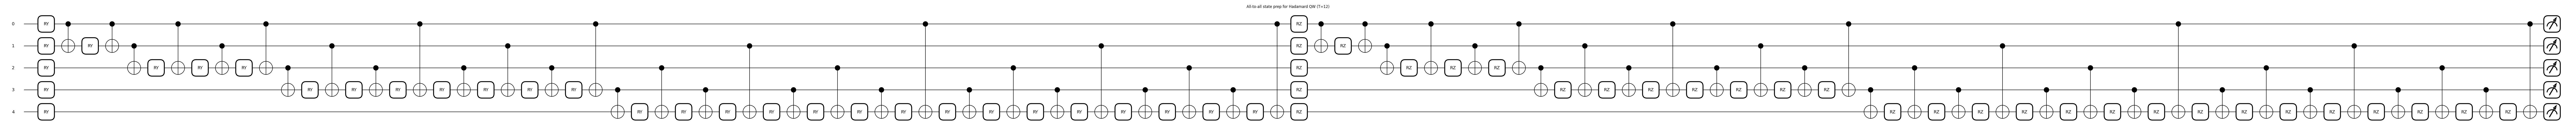

In [70]:
T = 12
circ_draw, _ = hadamard_qw_all_to_all_sampler(T, shots=1)
fig, ax = qml.draw_mpl(circ_draw)()
fig.suptitle(f"All-to-all state prep for Hadamard QW (T={T})")
plt.show()


N=24, shots=50000
  mean: 11.9756   (ideal 12.0000)
  var:  42.5002  (ideal 42.5859)
  TVD:  6.7339e-03


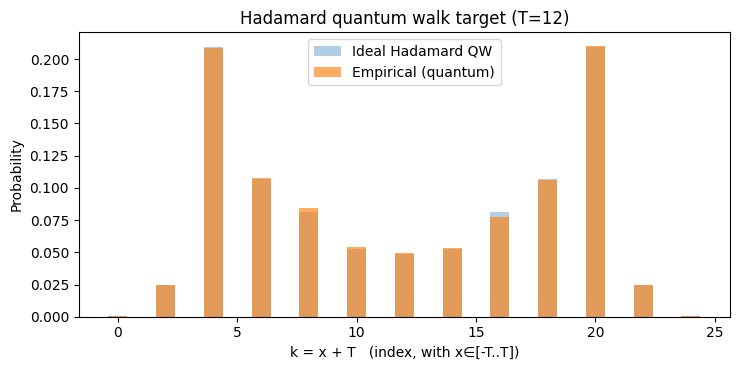

In [71]:
SHOTS = 50_000
T = 12
circ, ideal = hadamard_qw_all_to_all_sampler(T, shots=SHOTS)

bits = circ()                              # shape (shots, m) or (shots,)
ints_msb = bits_to_int(bits, "msb")
ints_lsb = bits_to_int(bits, "lsb")

N = len(ideal) - 1
bad_msb = np.count_nonzero(ints_msb > N)
bad_lsb = np.count_nonzero(ints_lsb > N)
ints = ints_msb if bad_msb <= bad_lsb else ints_lsb

# Safety check: target has zero outside 0..N
if np.count_nonzero(ints > N) > 0:
    raise RuntimeError("Mapping produced indices > N; check wire order/state prep.")

title = f"Hadamard quantum walk target (T={T})"
summarize_vs_ideal(ints, ideal, title=title)
